## Importing the Libraries:

In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import pickle
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

## Data Analysis:

In [2]:
base_dir = "./ranzcr_clip_catheter_line_classification/"

train_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
train_df.head()
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [3]:
train_df.nunique()

StudyInstanceUID              30083
ETT - Abnormal                    2
ETT - Borderline                  2
ETT - Normal                      2
NGT - Abnormal                    2
NGT - Borderline                  2
NGT - Incompletely Imaged         2
NGT - Normal                      2
CVC - Abnormal                    2
CVC - Borderline                  2
CVC - Normal                      2
Swan Ganz Catheter Present        2
PatientID                      3255
dtype: int64

In [4]:
train_df.shape
#13 - 2 = 11 labels which was also mentioned in the dataset description.
#That being said, there are two columns "StudyInstanceUID" and "PatientID" which do not hold valuable information. So, they can be dropped.

(30083, 13)

In [5]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
431dfc8cb      1
7f3c656e8      1
dfcf6cb39      1
1ea898eeb      1
cf83b24db      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


<BarContainer object of 11 artists>

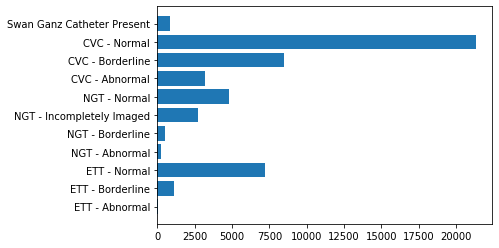

In [6]:
#plot label distrobution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
print(categoryCounts)
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])

#So according to the graph, most of the people had Normal condition in all three criteria "CVC", "NGT", and "ETT".

## Load the data:

In [7]:
#load x and y data
Xtrain = pickle.load(open("train.pickle", "rb"))
ytrain = pickle.load(open("target.pickle", "rb"))
pid = pickle.load(open("id.pickle", "rb"))

In [8]:
# Xtrain
Xtrain.shape #verified!

(500, 224, 224)

In [9]:
# ytrain
ytrain.shape

(500, 11)

In [10]:
# pid #is an array of arrays
pid.shape

(85,)

In [11]:
# train_df.iloc[[14, 29330], :] #verified!

## Scaling the data

In [12]:
#scale to 0-1

Xtrain_scaled = []
for pic in Xtrain:
    Xtrain_scaled.append(np.array(pic/255).astype(np.float32))
Xtrain_scaled

[array([[0.00392157, 0.00784314, 0.00784314, ..., 0.01176471, 0.00784314,
         0.00784314],
        [0.01176471, 0.00784314, 0.00784314, ..., 0.01568628, 0.01176471,
         0.00392157],
        [0.00784314, 0.00784314, 0.00784314, ..., 0.01568628, 0.01176471,
         0.01176471],
        ...,
        [0.00784314, 0.01176471, 0.01176471, ..., 0.22745098, 0.14901961,
         0.07843138],
        [0.00784314, 0.01176471, 0.01176471, ..., 0.23921569, 0.16470589,
         0.09411765],
        [0.00784314, 0.00784314, 0.00784314, ..., 0.23529412, 0.17254902,
         0.09803922]], dtype=float32),
 array([[0.03529412, 0.02745098, 0.02745098, ..., 0.07450981, 0.07843138,
         0.07843138],
        [0.02745098, 0.02745098, 0.02745098, ..., 0.07058824, 0.06666667,
         0.07843138],
        [0.02745098, 0.02745098, 0.02745098, ..., 0.06666667, 0.0627451 ,
         0.07058824],
        ...,
        [0.3647059 , 0.34509805, 0.33333334, ..., 0.64705884, 0.654902  ,
         0.6901961 

In [13]:
len(Xtrain_scaled) #verified!

500

## Solving data leakage issue in features:

In [14]:
#since "pid" has repetitive elemetns, we should faltten it into variable "lst":
# All the pid items in a single list:

lst = []

for i in range(0, len(pid)):
    for j in range(0, len(pid[i])):
        lst.append(pid[i][j])
lst.sort()
lst = np.unique(lst)
# lst.shape

In [15]:
lst

array([  0,   2,  11,  16,  17,  21,  24,  25,  26,  29,  31,  32,  39,
        43,  49,  51,  53,  59,  61,  63,  65,  74,  75,  76,  79,  82,
        83,  96,  98, 100, 103, 109, 112, 114, 115, 116, 117, 121, 125,
       133, 137, 140, 145, 149, 151, 157, 158, 160, 161, 167, 168, 169,
       174, 176, 180, 183, 188, 190, 196, 202, 204, 208, 209, 210, 213,
       226, 227, 234, 235, 237, 242, 245, 253, 257, 258, 263, 268, 271,
       272, 276, 279, 281, 282, 286, 293, 294, 298, 299, 300, 306, 311,
       312, 319, 320, 321, 327, 330, 333, 336, 337, 343, 347, 348, 350,
       355, 360, 361, 362, 365, 366, 370, 372, 373, 387, 391, 398, 399,
       401, 408, 410, 414, 415, 416, 421, 422, 430, 433, 435, 437, 440,
       441, 444, 447, 448, 453, 458, 459, 461, 471, 475, 477, 478, 481,
       482, 488, 489, 492, 495, 499])

In [16]:
#repeteted list:

Xtrain_arr = np.array(Xtrain_scaled)
repeted_lst = []

for i in range(0, len(lst)):
    repeted_lst.append(Xtrain_arr[lst[i]])

repeted_lst = np.array(repeted_lst)
# repeted_lst.shape

In [17]:
#polished list:

Xtrain_polished = []

for i in range(0, len(Xtrain_arr)):
    if i in lst:
        pass
    else:
        Xtrain_polished.append(Xtrain_arr[i])

Xtrain_polished = np.array(Xtrain_polished)
# Xtrain_polished.shape

## Scaling the images:

In [18]:
#reshapeing the train images "Xtrain_scaled":

repeted_lst_scaled = repeted_lst.reshape((-1, 224, 224, 1))
Xtrain_polished_scaled = Xtrain_polished.reshape((-1, 224, 224, 1))

# repeted_lst_scaled.max() #verified
# Xtrain_polished_scaled.max() #verified

In [19]:
print(repeted_lst_scaled.shape) #verified
print(Xtrain_polished_scaled.shape) #verified

(149, 224, 224, 1)
(351, 224, 224, 1)


## Solving data leakage issue in labels:

In [20]:
#repeteted list:

repeted_y = ytrain[lst, :]
# repeted_y.shape

#..............#
#the four categories ETT, NGT, CVC, SG: 
repeted_ytrain_ETT = repeted_y[:, 0:3] #0, 1, 2
repeted_ytrain_NGT = repeted_y[:, 3:7] #3, 4, 5, 6
repeted_ytrain_CVC = repeted_y[:, 7:10]  #7, 8, 9
repeted_ytrain_sg = repeted_y[:, 10:11]  #10

In [21]:
#polished list:

polished_y = []

for i in range(0, len(ytrain)):
    if i in lst:
        pass
    else:
        polished_y.append(ytrain[i])
        
polished_y = np.array(polished_y)
# polished_y.shape

#..............#
#the four categories ETT, NGT, CVC, SG:
polished_ytrain_ETT = polished_y[:, 0:3] #0, 1, 2
polished_ytrain_NGT = polished_y[:, 3:7] #3, 4, 5, 6
polished_ytrain_CVC = polished_y[:, 7:10]  #7, 8, 9
polished_ytrain_sg = polished_y[:, 10:11]  #10

## Train-test split ETT: (requires a class of 3 in the output layer)

In [22]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_ETT, x_test_ETT, y_train_ETT, y_test_ETT = train_test_split(Xtrain_polished_scaled, polished_ytrain_ETT, test_size = 0.15, random_state = 0) #, shuffle = True

In [23]:
print(x_train_ETT.shape)
print(y_train_ETT.shape)
print(x_test_ETT.shape)
print(y_test_ETT.shape)

(298, 224, 224, 1)
(298, 3)
(53, 224, 224, 1)
(53, 3)


In [24]:
#Adding the repeted data to x_train:
x_train_added_ETT = np.array([])
x_train_added_ETT = np.append(x_train_ETT, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_ETT = np.array([])
y_train_added_ETT = np.append(y_train_ETT, repeted_ytrain_ETT, axis = 0)

In [25]:
print(x_train_added_ETT.shape) #verified!
print(y_train_added_ETT.shape) #verified!

(447, 224, 224, 1)
(447, 3)


## Train-test split NGT: (requires a class of 4 in the output layer)

In [26]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_NGT, x_test_NGT, y_train_NGT, y_test_NGT = train_test_split(Xtrain_polished_scaled, polished_ytrain_NGT, test_size = 0.15, random_state = 0) #, shuffle = True

In [27]:
print(x_train_NGT.shape)
print(y_train_NGT.shape)
print(x_test_NGT.shape)
print(y_test_NGT.shape)

(298, 224, 224, 1)
(298, 4)
(53, 224, 224, 1)
(53, 4)


In [28]:
#Adding the repeted data to x_train:
x_train_added_NGT = np.array([])
x_train_added_NGT = np.append(x_train_NGT, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_NGT = np.array([])
y_train_added_NGT = np.append(y_train_NGT, repeted_ytrain_NGT, axis = 0)

In [29]:
print(x_train_added_NGT.shape) #verified!
print(y_train_added_NGT.shape) #verified!

(447, 224, 224, 1)
(447, 4)


## Train-test split CVC: (requires a class of 3 in the output layer)

In [30]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_CVC, x_test_CVC, y_train_CVC, y_test_CVC = train_test_split(Xtrain_polished_scaled, polished_ytrain_CVC, test_size = 0.15, random_state = 0) #, shuffle = True

In [31]:
print(x_train_CVC.shape)
print(y_train_CVC.shape)
print(x_test_CVC.shape)
print(y_test_CVC.shape)

(298, 224, 224, 1)
(298, 3)
(53, 224, 224, 1)
(53, 3)


In [32]:
#Adding the repeted data to x_train:
x_train_added_CVC = np.array([])
x_train_added_CVC = np.append(x_train_CVC, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_CVC = np.array([])
y_train_added_CVC = np.append(y_train_CVC, repeted_ytrain_CVC, axis = 0)

In [33]:
print(x_train_added_CVC.shape) #verified!
print(y_train_added_CVC.shape) #verified!

(447, 224, 224, 1)
(447, 3)


## Train-test split SG: (requires a class of 1 in the output layer)

In [34]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_SG, x_test_SG, y_train_SG, y_test_SG = train_test_split(Xtrain_polished_scaled, polished_ytrain_sg, test_size = 0.15, random_state = 0) #, shuffle = True

In [35]:
print(x_train_SG.shape)
print(y_train_SG.shape)
print(x_test_SG.shape)
print(y_test_SG.shape)

(298, 224, 224, 1)
(298, 1)
(53, 224, 224, 1)
(53, 1)


In [36]:
#Adding the repeted data to x_train:
x_train_added_SG = np.array([])
x_train_added_SG = np.append(x_train_SG, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_SG = np.array([])
y_train_added_SG = np.append(y_train_SG, repeted_ytrain_sg, axis = 0)

In [37]:
print(x_train_added_SG.shape) #verified!
print(y_train_added_SG.shape) #verified!

(447, 224, 224, 1)
(447, 1)


## Model ETT: CNN 

In [38]:
# build a sequential model

model_ETT = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_ETT.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_ETT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_ETT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
model_ETT.add(BatchNormalization())
# ANN block
model_ETT.add(Flatten())
model_ETT.add(Dense(units = 128, activation = 'relu'))
model_ETT.add(Dense(units = 128, activation = 'relu'))
model_ETT.add(Dropout(0.5))
# output layer
model_ETT.add(Dense(units = 3, activation = 'softmax'))
 
# compile model
model_ETT.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_ETT.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_ETT.fit(x = x_train_added_ETT, y = y_train_added_ETT, epochs = 1000, batch_size = 32, validation_data = [x_test_ETT, y_test_ETT], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        2

In [40]:
model_ETT.metrics_names

['loss', 'accuracy']

In [41]:
metrics = pd.DataFrame(model_ETT.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.516934,0.255034,0.271272,0.773585
1,0.180039,0.270694,0.193079,0.169811
2,0.158346,0.255034,0.163509,0.169811
3,0.163718,0.266219,0.141621,0.169811
4,0.103018,0.272931,0.142383,0.169811


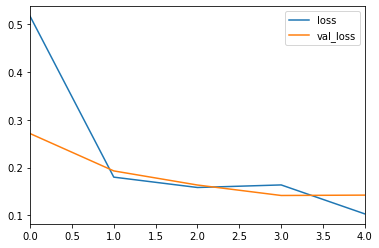

In [42]:
metrics[['loss', 'val_loss']].plot()

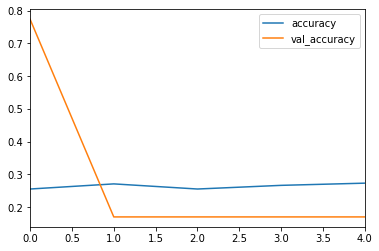

In [43]:
metrics[['accuracy', 'val_accuracy']].plot()

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_ETT.predict(x_test_ETT)
# confusion_matrix(y_test_ETT, y_pred)
# accuracy_score(y_test_ETT, y_pred)

In [46]:
x_test_ETT.shape

(53, 224, 224, 1)

In [47]:
img_ex = x_test_ETT[0].reshape(224, 224)

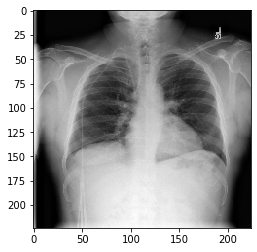

In [48]:
plt.imshow(img_ex, cmap="gray")

In [49]:
y_pred_ETT = model_ETT.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_ETT.astype(np.int32)

array([[0, 0, 0]])

In [50]:
y_pred_ETT.shape

(1, 3)

## Model NGT: CNN 

In [52]:
# build a sequential model

model_NGT = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_NGT.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_NGT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_NGT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
model_NGT.add(BatchNormalization())
# ANN block
model_NGT.add(Flatten())
model_NGT.add(Dense(units = 128, activation = 'relu'))
model_NGT.add(Dense(units = 128, activation = 'relu'))
model_NGT.add(Dropout(0.5))
# output layer
model_NGT.add(Dense(units = 4, activation = 'softmax'))
 
# compile model
model_NGT.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_NGT.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_NGT.fit(x = x_train_added_NGT, y = y_train_added_NGT, epochs = 1000, batch_size = 32, validation_data = [x_test_NGT, y_test_NGT], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 64)       

In [53]:
model_NGT.metrics_names

['loss', 'accuracy']

In [54]:
metrics = pd.DataFrame(model_NGT.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.540796,0.208054,0.223788,0.018868
1,0.318955,0.149888,0.217664,0.113208
2,0.316417,0.152125,0.209314,0.094340
3,0.247733,0.183445,0.219948,0.018868


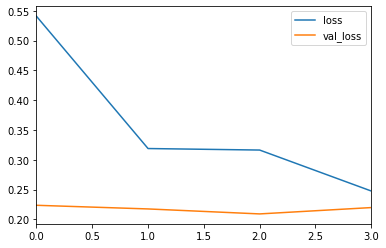

In [55]:
metrics[['loss', 'val_loss']].plot()

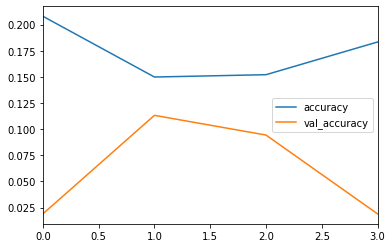

In [56]:
metrics[['accuracy', 'val_accuracy']].plot()

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_NGT.predict(x_test_NGT)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

In [58]:
x_test_NGT.shape

(53, 224, 224, 1)

In [59]:
img_ex = x_test_NGT[0].reshape(224, 224)

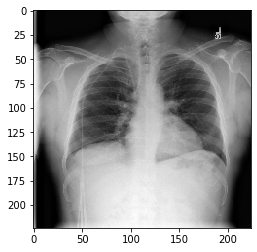

In [60]:
plt.imshow(img_ex, cmap="gray")

In [61]:
y_pred_NGT = model_NGT.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_NGT.astype(np.int32)

array([[0, 0, 0, 0]])

In [62]:
y_pred_NGT.shape

(1, 4)

## Model CVC: CNN 

In [63]:
# build a sequential model

model_CVC = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_CVC.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_CVC.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_CVC.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
model_CVC.add(BatchNormalization())
# ANN block
model_CVC.add(Flatten())
model_CVC.add(Dense(units = 128, activation = 'relu'))
model_CVC.add(Dense(units = 128, activation = 'relu'))
model_CVC.add(Dropout(0.5))
# output layer
model_CVC.add(Dense(units = 3, activation = 'softmax'))
 
# compile model
model_CVC.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_CVC.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_CVC.fit(x = x_train_added_CVC, y = y_train_added_CVC, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)       

In [64]:
model_CVC.metrics_names

['loss', 'accuracy']

In [65]:
metrics = pd.DataFrame(model_CVC.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.413478,0.496644,1.123772,0.433962
1,1.000141,0.554810,1.033424,0.735849
2,0.944514,0.568233,1.039700,0.735849


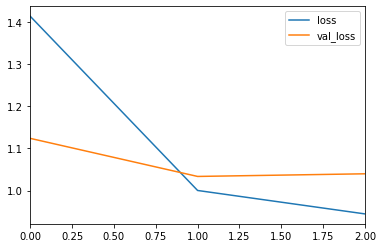

In [66]:
metrics[['loss', 'val_loss']].plot()

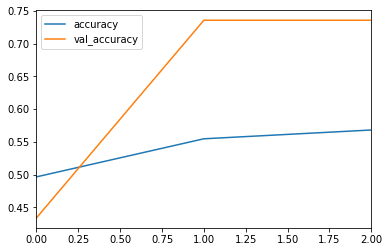

In [67]:
metrics[['accuracy', 'val_accuracy']].plot()

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_CVC.predict(x_test_CVC)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

In [69]:
x_test_CVC.shape

(53, 224, 224, 1)

In [70]:
img_ex = x_test_CVC[0].reshape(224, 224)

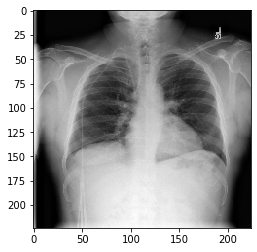

In [71]:
plt.imshow(img_ex, cmap="gray")

In [72]:
y_pred_CVC = model_CVC.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_CVC.astype(np.int32)

array([[0, 0, 0]])

In [73]:
y_pred_CVC.shape

(1, 3)

## Model SG: CNN 

In [76]:
# build a sequential model

model_SG = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_SG.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_SG.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_SG.add(Conv2D(64, (3, 3), activation = 'relu'))
model_SG.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_SG.add(Conv2D(64, (3, 3), activation = 'relu'))
model_SG.add(MaxPool2D(pool_size = (2, 2)))
model_SG.add(BatchNormalization())
# ANN block
model_SG.add(Flatten())
model_SG.add(Dense(units = 128, activation = 'relu'))
model_SG.add(Dense(units = 128, activation = 'relu'))
model_SG.add(Dropout(0.5))
# output layer
model_SG.add(Dense(units = 1, activation = 'sigmoid'))
 
# compile model
model_SG.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_SG.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_SG.fit(x = x_train_added_SG, y = y_train_added_SG, epochs = 1000, batch_size = 32, validation_data = [x_test_SG, y_test_SG], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 64)       

In [77]:
model_SG.metrics_names

['loss', 'accuracy']

In [78]:
metrics = pd.DataFrame(model_SG.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.334676,0.930649,0.676961,0.603774
1,0.232440,0.957494,0.177369,0.962264
2,0.156047,0.961969,0.234289,0.962264


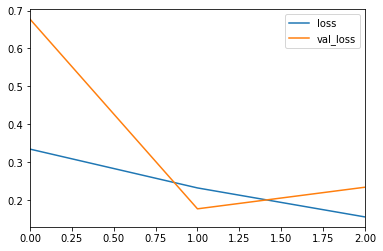

In [79]:
metrics[['loss', 'val_loss']].plot()

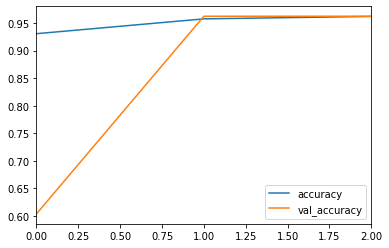

In [80]:
metrics[['accuracy', 'val_accuracy']].plot()

In [81]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_SG.predict(x_test_SG)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

In [82]:
x_test_SG.shape

(53, 224, 224, 1)

In [83]:
img_ex = x_test_SG[0].reshape(224, 224)

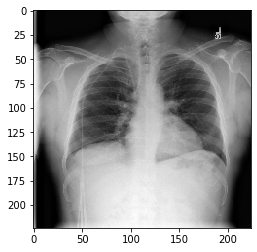

In [84]:
plt.imshow(img_ex, cmap="gray")

In [85]:
y_pred_SG = model_SG.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_SG.astype(np.int32)

array([[0]])

In [86]:
y_pred_SG.shape

(1, 1)

## Results:

In [ ]:
#Among all the diffrenet four catgories ETT, NGT, CVC, and SG the SG had the higheset accuracy.
#The reason could be that it is a binary classification; hence, demands less computations from the CNN model side.
#Another reason could be that the SG metric is quite clear and doesn't actually have particular hidden relationships to be discovered. 